# Abstract

**Author:** [Charles Tapley Hoyt](https://github.com/cthoyt)

**Estimated Run Time:** 4 minutes

This notebooks demonstrates the usage of a variant on the [Network Perturbation Amplitude](http://bmcsystbiol.biomedcentral.com/articles/10.1186/1752-0509-6-54) algorithm to analyze an BEL knowledge assembly in the context of a differential gene expression experiment. 

### Notebook Imports

In [1]:
import logging
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
from matplotlib_venn import venn2

import pybel
import pybel_tools as pbt
import pybel_tools.analysis.npa as npa
from pybel.constants import *
from pybel.canonicalize import calculate_canonical_name
from pybel_tools.visualization import to_jupyter

In [2]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

### Notebook Provenance

The time of execution, random number generator seed, and the versions of the software packages used are displayed explicitly.

In [3]:
time.asctime()

'Fri Mar 17 13:08:01 2017'

In [4]:
# seed the random number generator
import random
random.seed(127)

In [5]:
pybel.__version__

'0.4.2'

In [6]:
pbt.__version__

'0.1.3-dev'

### Local Path Definitions

In [7]:
bms_base = os.environ['BMS_BASE']
owncloud_base = os.environ['OWNCLOUD_BASE']

# Data

## Alzheimer's Disease Knowledge Assembly

The Alzheimer's Disease Knowledge Assembly has been precompiled with the following command line script, and will be loaded from this format for improved performance. In general, derived data, such as the gpickle representation of a BEL script, are not saved under version control to ensure that the most up-to-date data is always used.

```sh
pybel convert --path "$BMS_BASE/aetionomy/alzheimers.bel" --pickle "$BMS_BASE/aetionomy/alzheimers.gpickle"
```

The BEL script can also be compiled from inside this notebook with the following python code:

```python
>>> import os
>>> import pybel
>>> # Input from BEL script
>>> bel_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.bel')
>>> graph = pybel.from_path(bel_path)
>>> # Output to gpickle for fast loading later
>>> pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')
>>> pybel.to_pickle(graph, pickle_path)
```

In [8]:
pickle_path = os.path.join(bms_base, 'aetionomy', 'alzheimers.gpickle')

In [9]:
graph = pybel.from_pickle(pickle_path)

All orthologies are discared before analysis.

In [10]:
pbt.mutation.remove_nodes_by_namespace(graph, GENE, 'MGI')
pbt.mutation.remove_nodes_by_namespace(graph, RNA, 'MGI')
pbt.mutation.remove_nodes_by_namespace(graph, PROTEIN, 'MGI')

pbt.mutation.remove_nodes_by_namespace(graph, GENE, 'RGD')
pbt.mutation.remove_nodes_by_namespace(graph, RNA, 'RGD')
pbt.mutation.remove_nodes_by_namespace(graph, PROTEIN, 'RGD')

To merge the differential gene expression annotations, the entire graph must be collapsed to genes using `pbt.mutation.opening_by_central_dogma_to_genes`

In [11]:
pbt.mutation.opening_by_central_dogma_to_genes(graph)
pbt.mutation.collapse_variants_to_genes(graph)

In [12]:
pbt.summary.print_summary(graph)

Name: Alzheimer's Disease Model
Number of nodes: 9269
Number of edges: 58301
Network density: 0.0006786675695545498
Number weakly connected components: 55
Average in-degree: 6.289891034631568
Average out-degree: 6.289891034631568


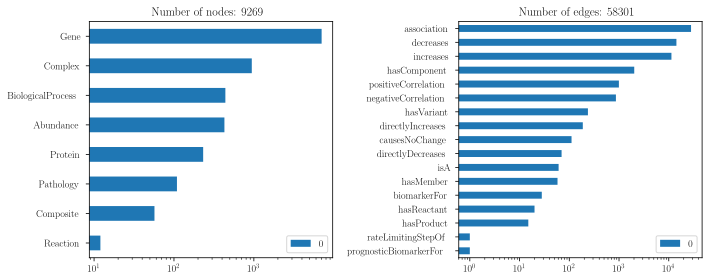

In [13]:
pbt.summary.plot_summary(graph, plt, figsize=(10, 4))
plt.show()

## Differential Gene Expression

Differential gene expression data can be obtained from many sources, including ADNI and other large clinical studies. This analysis is concerned with the log-fold-changes on each gene, and not necessarily the p-value. This is better as a data-driven process becuase it does not require a model or multiple hypothesis testing on raw data.

In [14]:
data_path = os.path.join(owncloud_base, 'SevAD.csv')
target_columns = ['Gene.symbol', 'logFC']

In [15]:
df = pd.read_csv(data_path)
df = df.loc[df['Gene.symbol'].notnull(), target_columns]
df.head()

,Gene.symbol,logFC
0,ZNF616,-4.244691
1,DEFB125,3.974393
3,SNAP23,3.337636
4,PHLDB2,3.192559
5,LOC389895,-4.296850


A histogram of the log-fold-changes shows that the data are normally distributed, as expected for differential gene expression data.

In [16]:
# max_fc = {}
# for row, symbol, fc in df.itertuples():
#    if symbol not in max_fc or abs(max_fc[symbol]) < abs(fc):
#        max_fc[symbol] = fc
        
data = {k: v for _, k, v in df.itertuples()}

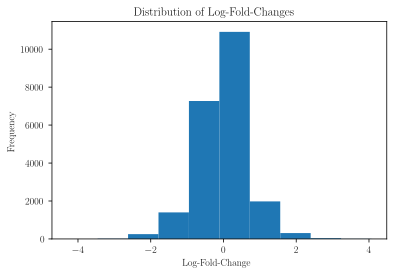

In [17]:
plt.title('Distribution of Log-Fold-Changes')
plt.xlabel('Log-Fold-Change')
plt.ylabel('Frequency')
plt.hist(list(data.values()))
plt.show()

## Overlap Summary

The number of shared elements in the knowledge assembly and differential gene data set are counted.

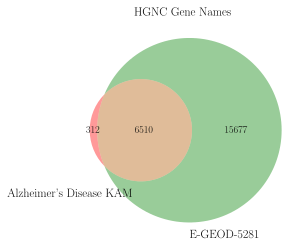

In [18]:
hgnc_names = pbt.summary.get_names(graph, 'HGNC')
df_names = set(df['Gene.symbol'])
overlapping_hgnc_names = hgnc_names & df_names

plt.title('HGNC Gene Names')
venn2([hgnc_names, df_names], set_labels=["Alzheimer's Disease KAM", 'E-GEOD-5281'])
plt.show()

# Analysis

## Data Integration

Finally, the differential gene expression data are ovelayed on the BEL graph with [pbt.integration.overlay_type_data](http://pybel-tools.readthedocs.io/en/latest/integration.html#pybel_tools.integration.overlay_type_data)

In [19]:
label = 'weight'

In [20]:
pbt.integration.overlay_type_data(graph, data, label, GENE, 'HGNC', overwrite=False, impute=0)

## Subgraph Generation

A subgraph is induced around an example biological process, Inflammatory Response, by selecting all of the source nodes of upstream causal edges, where this process is the target node. These networks are then enriched by expandind around all of those nodes' upstream edges as well.

In [21]:
inflamation_node = BIOPROCESS, 'GOBP', 'inflammatory response'

### Iteration 1/2

All of the nodes that have upstream causal relations to Inflammatory Response are added.

In [22]:
subgraph = pbt.mutation.get_upstream_causal_subgraph(graph, inflamation_node)

pbt.summary.print_summary(subgraph)
to_jupyter(subgraph)

Name: 
Number of nodes: 32
Number of edges: 53
Network density: 0.05342741935483871
Number weakly connected components: 1
Average in-degree: 1.65625
Average out-degree: 1.65625


<IPython.core.display.Javascript object>

### Iteration 2/2

All of the nodes upstream of the nodes within the subgraph are added as well.

In [23]:
pbt.mutation.expand_upstream_causal_subgraph(graph, subgraph)
pbt.summary.print_summary(subgraph)

Name: 
Number of nodes: 278
Number of edges: 1188
Network density: 0.01542736929589902
Number weakly connected components: 1
Average in-degree: 4.273381294964029
Average out-degree: 4.273381294964029


### Post-Processing

Inconsistient edges are thrown away, literature bias is removed, and nodes on the periphery of the subgraph that are not annotated with experimental data are also removed, since they cannot contribute to the propogation of scores.

In [24]:
pbt.mutation.remove_inconsistent_edges(graph)

In [25]:
pbt.mutation.collapse_consistent_edges(graph)

In [26]:
pbt.generation.remove_unweighted_leaves(subgraph, label)

In [27]:
pbt.generation.remove_unweighted_sources(subgraph, label)

In [28]:
pbt.summary.print_summary(subgraph)
to_jupyter(subgraph)

Name: 
Number of nodes: 129
Number of edges: 740
Network density: 0.04481589147286822
Number weakly connected components: 1
Average in-degree: 5.736434108527132
Average out-degree: 5.736434108527132


<IPython.core.display.Javascript object>

This entire procedure can be run automatically with [pbt.generation.generate_mechanism](http://pybel-tools.readthedocs.io/en/latest/generation.html#pybel_tools.generation.generate_mechanism)

## Running

In [29]:
runner = npa.NpaRunner(subgraph, inflamation_node, label)

While the algorithm can be immediately run with [pbt.analysis.npa.NpaRunner.run](http://pybel-tools.readthedocs.io/en/latest/npa.html#pybel_tools.analysis.npa.NpaRunner.run), the process is outlined to show the evolution of the graph throughouts its steps. For animation purposes, the functin [pbt.analysis.npa.NpaRunner.run_with_graph_transformation](http://pybel-tools.readthedocs.io/en/latest/npa.html#pybel_tools.analysis.npa.NpaRunner.run_with_graph_transformation) yields a new `BELGraph` at each step through the process as well.

In [30]:
runner.score_leaves()

{('Abundance', 'BRCO', 'Astrocyte'),
 ('Abundance', 'CHEBI', 'leukotriene'),
 ('Abundance', 'MESHCS', 'Neurofibrillary Tangles'),
 ('Gene', 'HGNC', 'CD14'),
 ('Gene', 'HGNC', 'CHI3L1'),
 ('Gene', 'HGNC', 'IL23A'),
 ('Gene', 'HGNC', 'IRAK1'),
 ('Gene', 'HGNC', 'IRAK2'),
 ('Gene', 'HGNC', 'PTX3'),
 ('Gene', 'HGNC', 'TLR2')}

In [31]:
to_jupyter(runner.get_remaining_graph(), height=400)

<IPython.core.display.Javascript object>

In [32]:
runner.score_leaves()

{('Gene', 'HGNC', 'IL12B')}

In [33]:
to_jupyter(runner.get_remaining_graph(), height=400)

<IPython.core.display.Javascript object>

In [34]:
runner.score_leaves()

set()

In [35]:
runner.remove_random_edge()

to_jupyter(runner.get_remaining_graph(), height=400)

<IPython.core.display.Javascript object>

In [36]:
runner.score_leaves()

{('Gene', 'HGNC', 'SCARB1')}

In [37]:
runner.score_leaves()

set()

In [38]:
runner.remove_random_edge()
leaves = runner.score_leaves()
len(leaves)

1

In [39]:
to_jupyter(runner.get_remaining_graph(), height=400)

<IPython.core.display.Javascript object>

In [40]:
runner.run()

In [41]:
runner.get_final_score()

89.865252220001963

## Robustness Analysis

The algorithm is random, so it can be run multiple times to assess the robustness of the final scores using [pbt.analysis.npa.multirun](http://pybel-tools.readthedocs.io/en/latest/npa.html#pybel_tools.analysis.npa.multirun)

In [42]:
%%time

runners = list(npa.multirun(subgraph, inflamation_node, label, default_score=0, runs=500))

CPU times: user 23.1 s, sys: 310 ms, total: 23.4 s
Wall time: 23.5 s


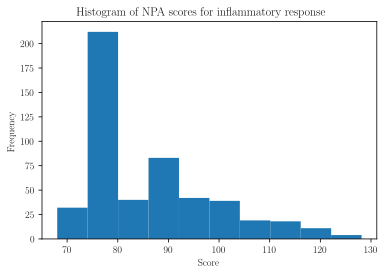

In [43]:
plt.title('Histogram of NPA scores for {}'.format(calculate_canonical_name(subgraph, inflamation_node)))
plt.ylabel('Frequency')
plt.xlabel('Score')
plt.hist([runner.get_final_score() for runner in runners])
plt.show()

## Full Workflow

This workflow can all be run with [pbt.analysis.npa.workflow_all_average](http://pybel-tools.readthedocs.io/en/latest/npa.html#pybel_tools.analysis.npa.workflow_all_average) but is outlined here for a deeper understanding.

### Generate Candidate Mechanisms

Candidate mechanism are generated with the aforementioned function [pbt.generation.generate_mechanism](http://pybel-tools.readthedocs.io/en/latest/generation.html#pybel_tools.generation.generate_mechanism) to assess the upstream causal subgraphs of all biological processes.

In [44]:
all_bioprocesses = pbt.selection.get_nodes_by_function(graph, BIOPROCESS)

In [45]:
%%time

candidate_mechanisms = {node: pbt.generation.generate_mechanism(graph, node, label) for node in all_bioprocesses}

CPU times: user 2.17 s, sys: 34.1 ms, total: 2.21 s
Wall time: 2.22 s


The algorithm is run over all candidate subgraphs that are nontrivial (have more than one node in them) and a pandas DataFrame is prepared.

In [46]:
%%time

scores = {}

for node, subgraph in candidate_mechanisms.items():
    
    fneighbors = subgraph.in_degree(node)
    fneighbors = 0 if isinstance(fneighbors, dict) else fneighbors
    size = subgraph.number_of_nodes()
    
    if size <= 1:  # Can't calculate a score for empty subgraphs
        score = None
    else:
        score = npa.multirun_average(subgraph, node, label, runs=40)
    
    scores[node] = (score, fneighbors, size)

CPU times: user 21.4 s, sys: 109 ms, total: 21.5 s
Wall time: 21.6 s


In [47]:
len(candidate_mechanisms), sum(1 for score, _, _ in scores.values() if score)

(440, 239)

In [48]:
# Optionally, calcualte "cute names" for the nodes
# scores = {calculate_canonical_name(graph, n): s for n, s in scores.items()}

scores_df = pd.DataFrame.from_items(scores.items(), orient='index', columns=['Average NPA Score','Number First Neighbors','Subgraph Size'])

A scatter matrix is shown below. The distribution of average NPA scores is shown to be mostly normal. The following scatter plots show small, non-linear relationships between average NPA score and the subgraph size and the number of first neighbors of the seed node. The trivial positive correlation between number of first neighbors is also shown.

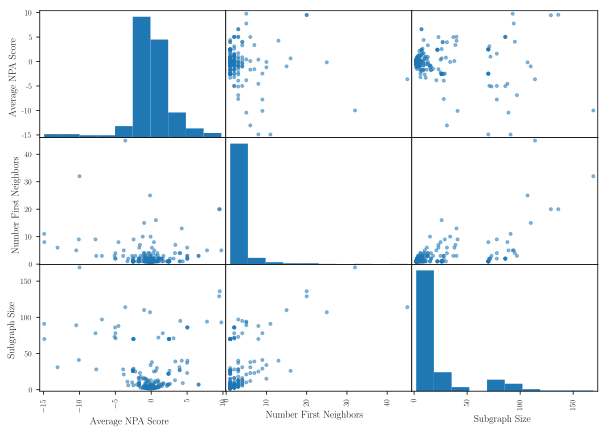

In [49]:
scatter_matrix(scores_df[scores_df['Average NPA Score'].notnull()], figsize=(10, 7))
plt.show()

In [50]:
scores_df.to_csv(os.path.expanduser('~/Desktop/npa_demo.csv'))

In [51]:
scores_df[scores_df['Average NPA Score'].notnull()].sort_values('Average NPA Score')

,Average NPA Score,Number First Neighbors,Subgraph Size
"(BiologicalProcess, GOBP, cell death)",-14.918127,11,91
"(BiologicalProcess, GOBP, positive regulation of neuron apoptotic process)",-14.896657,8,70
"(BiologicalProcess, GOBP, glial cell differentiation)",-13.059167,6,31
"(BiologicalProcess, GOBP, chronic inflammatory response)",-10.446388,5,89
"(BiologicalProcess, GOBP, production of molecular mediator involved in inflammatory response)",-10.091692,9,41
"(BiologicalProcess, GOBP, neuron apoptotic process)",-9.998230,32,169
"(BiologicalProcess, GOBP, beta-amyloid formation)",-7.770215,9,78
"(BiologicalProcess, GOBP, cell-matrix adhesion)",-7.657543,3,28
"(BiologicalProcess, GOBP, negative regulation of neuron projection regeneration)",-6.872035,3,97
"(BiologicalProcess, GOBP, vasoconstriction)",-5.107942,3,73


# Conclusions

## Problems

This algorithm overcomes deterministic problems with cyclic graphs by randomly removing edges. It can be run multiple times to assess the stability of the score with `pbt.analysis.npa.average_npa_run`. The effect of the default score can also be checked with a grid search.

## Looking Forward

While this new algorithm is generally applicable and overcomes the original algorithm, it must throw away information to do so. Further algorithmic development, such as heat diffusion approaches could allow for a more thorough investigation of the propogation of effects of the differential gene expression.

This algorithm can be run over the mechanisms generated for each biological process. Further investigation into the upstream mechanism generation can yield bias-free candidate mechanisms. They can also be matched to canonical mechanisms in NeuroMMSigDB to identify concordance between the biological dogma and all possible mechanisms, then to identify previously unknown cross-talk between mechanisms.